# ДЗ 8

```
На сайте запущен А/В тест с целью увеличить доход.
В приложенном excel файле вы найдете сырые данные по результатам эксперимента – user_id,
тип выборки variant_name и доход принесенный пользователем revenue.
Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.
```

In [3]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

In [4]:
# Загрузка данных
# from google.colab import drive
# drive.mount("/content/drive")

# df = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/A_B tests HW8 raw.xlsx")

df = pd.read_excel("A_B tests HW8 raw.xlsx")

df.head(10)

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
5,2380,variant,0.0
6,2849,control,0.0
7,9168,control,0.0
8,6205,variant,0.0
9,7548,control,0.0


## Анализ данных

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [6]:
df.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


In [7]:
rev_test_values = df.query('VARIANT_NAME == "variant"').REVENUE.values
rev_control_values = df.query('VARIANT_NAME == "control"').REVENUE.values

conv_test_values = df.query('VARIANT_NAME == "variant" & REVENUE > 0').REVENUE.values
conv_control_values = df.query('VARIANT_NAME == "control" & REVENUE > 0').REVENUE.values

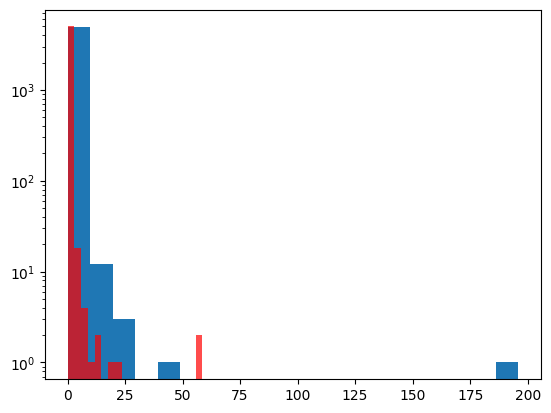

In [8]:
plt.hist(rev_control_values, bins=20, log=True)
plt.hist(rev_test_values, bins=20, log=True, color='red', alpha=0.7)
plt.show()

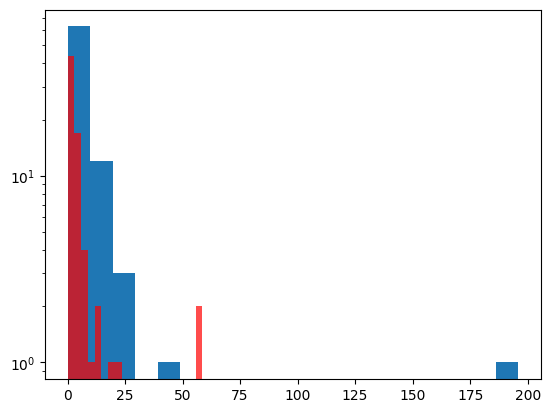

In [9]:
# расперделение по совершённым покупкам
plt.hist(conv_control_values, bins=20, log=True)
plt.hist(conv_test_values, bins=20, log=True, color='red', alpha=0.7)
plt.show()

In [10]:
# для очистки совести
stats.shapiro(conv_control_values)[1], \
stats.shapiro(conv_test_values)[1], \
stats.shapiro(rev_control_values)[1], \
stats.shapiro(rev_test_values)[1]

(6.5033072107817044e-18, 2.1140220769002042e-15, 0.0, 0.0)

In [11]:
# проверка на вхождение пользователей только в одну из проверяемых групп:
def isSameGroup(data):
    return len(data.unique()) <= 1

df.groupby('USER_ID').VARIANT_NAME.agg(isSameGroup).value_counts()

True     4783
False    1541
Name: VARIANT_NAME, dtype: int64

Вывод: данные распределены не нормально. Есть выбросы. Большое количество пользователей оказалось в обеих группах.

На этом можно было бы и закончить, но для полноты анализа применяем критерий Манна-Уитни.

In [12]:
stats.mannwhitneyu(
    x=rev_control_values,
    y=rev_test_values
)

MannwhitneyuResult(statistic=12521564.0, pvalue=0.47825247965294926)

In [13]:
# Для пользователей, совершивших покупку:
stats.mannwhitneyu(
    x=df.query('VARIANT_NAME == "control" & REVENUE > 0').REVENUE.values,
    y=df.query('VARIANT_NAME == "variant" & REVENUE > 0').REVENUE.values
)

MannwhitneyuResult(statistic=3356.0, pvalue=0.07924299810603061)

## Анализ мощности теста

In [14]:
import statsmodels.stats.power as pwr

In [15]:
mean_control = rev_control_values.mean()
mean_test = rev_test_values.mean()
std_control = rev_control_values.std()
std_test = rev_test_values.std()

n = len(df)

effect = (mean_test - mean_control) / np.sqrt((std_test**2 + std_control**2) / 2)

In [16]:
ALPHA = 0.05

analysis = pwr.TTestIndPower()
analysis.solve_power(
    effect,
    power=None,
    nobs1=n,
    ratio=1.0,
    alpha=ALPHA
)

0.43490504712856837

Вывод: данные по тестовой группе не показывают статистически значимых отличий для α=0.05. Однако мы имеем недостаточную мощность теста и ошибки сплитования. 

Рекомендуется увеличить время тестирования для накопления данных и распределить пользователей строго по разным группам.